# Regression of CONUS precipitation on Nino 3.4 index

## Introduction

Here, we will use linear regression to evaluate the extent to which the Nino 3.4 index can be used as a predictor for average monthly precipitation of the coterminous USA. The Nino 3.4 index identifies the phase of the ENSO mode, one of the leading modes of global climate variability. It might therefore be reasonable to expect that the index would be a good predictor for long-term variations in precipitation. 

In order to assess this claim we will take a monthly averaged precipitation dataset and a time series of the monthly-averaged Nino 3.4 index for the same period and we will regress the Nino 3.4 index onto the precipitation data. We will thus be able to find the correlation between precipitation and Nino 3.4 at each grid point and for each month. We will use a simple t-test to identify regions where the correlation is statistically significantly non-zero (i.e. our null hypothesis is that Nino 3.4 and precipitation are uncorrelated, while our alternative hypothesis is that the correlation is non-zero) at the 95% level.

## Methods

First, we will load in the data, standardise it (subtract mean and divide by std), and crop the datasets to ensure they cover the same periods.

In [269]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import pandas as pd
import xarray as xr
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature

scale = '50m'
states50 = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale=scale,
            facecolor='none',
            edgecolor='r')

Can't find the prepared Nino3.4 index file anywhere on Canvas, so using the txt file from the NOAA website:

In [107]:
nino34 = pd.read_csv('nino34.long.txt',  delim_whitespace=True, skiprows = [0,1,153,154,155,156,157, 158])
nino34

,1871,26.33,26.18,26.83,27.27,27.16,27.16.1,26.62,26.54,26.51,26.40,26.35,26.01
0,1872,25.86,26.14,26.76,27.00,27.25,27.16,26.91,26.02,25.73,25.79,25.86,25.71
1,1873,25.79,25.75,25.95,27.10,27.33,27.21,26.65,26.48,26.41,25.96,25.88,25.89
2,1874,25.64,25.70,25.85,26.83,27.00,26.96,26.22,25.82,25.62,25.49,25.33,25.45
3,1875,25.87,26.39,26.66,26.90,26.77,26.92,26.37,26.06,25.84,25.90,26.01,25.83
4,1876,25.63,25.56,26.13,26.59,26.78,27.25,26.88,26.71,26.73,26.85,26.80,26.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,2017,26.24,26.75,27.17,27.99,28.17,27.91,27.44,26.69,26.20,26.21,25.81,25.74
146,2018,25.72,26.03,26.53,27.41,27.75,27.81,27.49,26.93,27.05,27.57,27.65,27.56
147,2019,27.09,27.38,28.06,28.44,28.48,28.34,27.64,27.07,26.86,27.29,27.39,27.10
148,2020,27.22,27.25,27.62,28.26,27.74,27.48,27.18,26.46,26.09,25.54,25.64,25.61


In [108]:
nino34 = np.array(nino34)
# select the years 1950-2018 and trim year from dataset:
nino34 = nino34[78:-4,1:]
nino34 = nino34.flatten()
nino34 = np.reshape(nino34,(68,12))
nino34_mean = np.nanmean(nino34, axis = 0)
nino34_std = np.nanstd(nino34, axis = 0)
nino34_standard = (nino34 - nino34_mean)/nino34_std

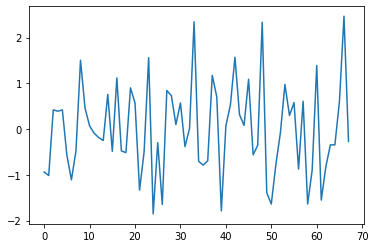

In [111]:
plt.plot(nino34_standard[:,0])

Now load precipitation data and edit to same years:

In [43]:
ds = xr.open_dataset('precip.V1.0.mon.mean2020.nc')
ds = ds.sel(time = slice('1950-01-01','2017-12-01'),drop=True)
ds

<xarray.Dataset>
Dimensions:  (lat: 120, lon: 300, time: 816)
Coordinates:
  * lat      (lat) float32 20.12 20.38 20.62 20.88 ... 49.12 49.38 49.62 49.88
  * lon      (lon) float32 230.1 230.4 230.6 230.9 ... 304.1 304.4 304.6 304.9
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2017-12-01
Data variables:
    precip   (time, lat, lon) float32 ...
Attributes:
    title:          CPC Unified Gauge-Based Analysis of Daily Precipitation o...
    Conventions:    COARDS
    history:        created 05/2012 by CAS from data obtained at NOAA NCEP/CPC
    description:    CPC Unified Gauge-Based Analysis of Daily Precipitation o...
    platform:       Observations
    Comments:       Preciptation is accumulated from 12z of previous day to 1...
    References:     http://www.esrl.noaa.gov/psd/data/gridded/data.unified.da...
    dataset_title:  CPC Unified Gauge-Based Analysis of Daily Precipitation o...

In [215]:
lon = np.array(ds['lon'])
lat = np.array(ds['lat'])

Calculate monthly climatology to remove average annual cycle:

In [112]:
ds_mean = ds.groupby("time.month").mean("time")
ds_mean

<xarray.Dataset>
Dimensions:  (lat: 120, lon: 300, month: 12)
Coordinates:
  * lat      (lat) float32 20.12 20.38 20.62 20.88 ... 49.12 49.38 49.62 49.88
  * lon      (lon) float32 230.1 230.4 230.6 230.9 ... 304.1 304.4 304.6 304.9
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    precip   (month, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

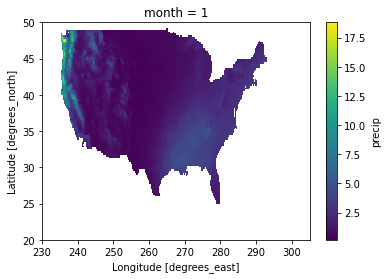

In [113]:
ds_mean['precip'].sel(month=1).plot()

In [114]:
ds_std = ds.groupby("time.month").std("time")
ds_std

<xarray.Dataset>
Dimensions:  (lat: 120, lon: 300, month: 12)
Coordinates:
  * lat      (lat) float32 20.12 20.38 20.62 20.88 ... 49.12 49.38 49.62 49.88
  * lon      (lon) float32 230.1 230.4 230.6 230.9 ... 304.1 304.4 304.6 304.9
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    precip   (month, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

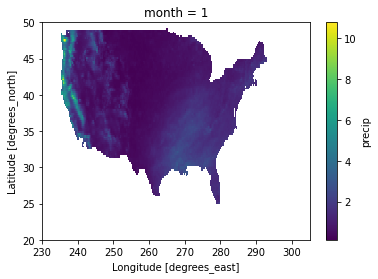

In [115]:
ds_std['precip'].sel(month=1).plot()

In [116]:
prcp = np.array(ds['precip'])
prcp = np.reshape(prcp, (68,12,120,300))

prcp_mean = np.array(ds_mean['precip'])
prcp_mean.shape

prcp_std = np.array(ds_std['precip'])
prcp_std.shape

# remove climatological mean
prcp_standard = (prcp - prcp_mean)/prcp_std

In [149]:
prcp_std.shape

(12, 120, 300)

Now that the data is ready, we can regress the Nino 3.4 index onto the precipitation data:

In [155]:
n_t = 12
n_lat = 120
n_lon = 300
rc = np.empty([n_t,n_lat,n_lon])
rp = np.empty([n_t,n_lat,n_lon])

for i in range(n_t):
    p = prcp_standard[:,i,:,:]
    n = nino34_standard[:,i]
    p = np.reshape(p,(68,n_lat*n_lon))
    # compute correlation matrix:
    c=n.dot(p)/68
    rc[i,:,:] = np.reshape(c,(n_lat,n_lon))
    # multiply by std to get regression coefficients:
    rp[i,:,:] = np.reshape(c*np.reshape(prcp_std[i,:,:],(n_lat*n_lon)),(n_lat,n_lon))


## Results

First, let's look at the correlations for each grid point and each season. Red indicates a positive correlation and blue a negative.

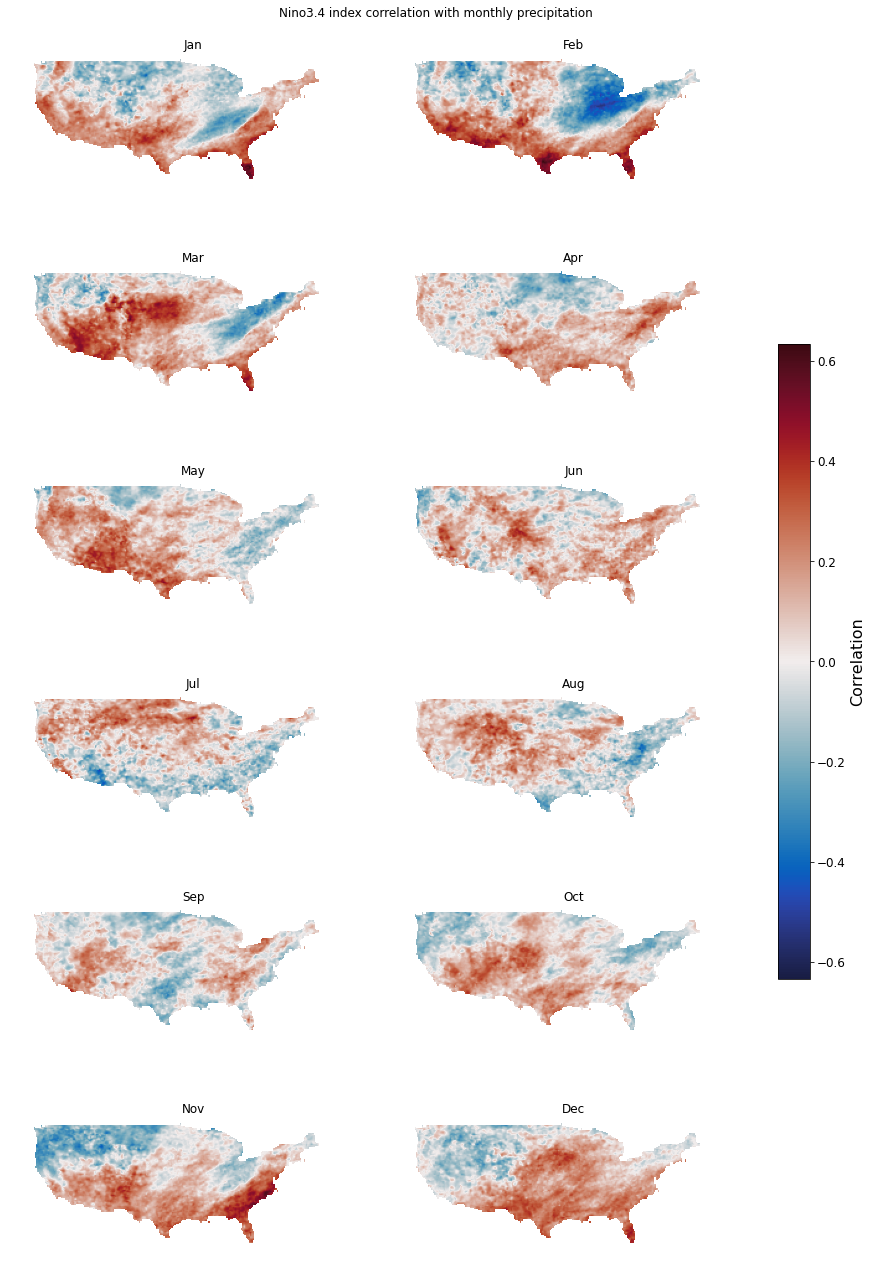

In [156]:
cbar_amp = np.nanmax(np.abs(rc))
fig, axs = plt.subplots(6,2,figsize = (12,18), constrained_layout = True)
im = axs[0,0].imshow(np.flipud(rc[0,:,:]), cmap = cmocean.cm.balance, vmin = -cbar_amp, vmax = cbar_amp)
axs[0,0].set_title('Jan')
axs[0,0].axis('off')
axs[0,1].imshow(np.flipud(rc[1,:,:]), cmap = cmocean.cm.balance, vmin = -cbar_amp, vmax = cbar_amp)
axs[0,1].set_title('Feb')
axs[0,1].axis('off')
axs[1,0].imshow(np.flipud(rc[2,:,:]), cmap = cmocean.cm.balance, vmin = -cbar_amp, vmax = cbar_amp)
axs[1,0].set_title('Mar')
axs[1,0].axis('off')
axs[1,1].imshow(np.flipud(rc[3,:,:]), cmap = cmocean.cm.balance, vmin = -cbar_amp, vmax = cbar_amp)
axs[1,1].set_title('Apr')
axs[1,1].axis('off')
axs[2,0].imshow(np.flipud(rc[4,:,:]), cmap = cmocean.cm.balance, vmin = -cbar_amp, vmax = cbar_amp)
axs[2,0].set_title('May')
axs[2,0].axis('off')
axs[2,1].imshow(np.flipud(rc[5,:,:]), cmap = cmocean.cm.balance, vmin = -cbar_amp, vmax = cbar_amp)
axs[2,1].set_title('Jun')
axs[2,1].axis('off')
axs[3,0].imshow(np.flipud(rc[6,:,:]), cmap = cmocean.cm.balance, vmin = -cbar_amp, vmax = cbar_amp)
axs[3,0].set_title('Jul')
axs[3,0].axis('off')
axs[3,1].imshow(np.flipud(rc[7,:,:]), cmap = cmocean.cm.balance, vmin = -cbar_amp, vmax = cbar_amp)
axs[3,1].set_title('Aug')
axs[3,1].axis('off')
axs[4,0].imshow(np.flipud(rc[8,:,:]), cmap = cmocean.cm.balance, vmin = -cbar_amp, vmax = cbar_amp)
axs[4,0].set_title('Sep')
axs[4,0].axis('off')
axs[4,1].imshow(np.flipud(rc[9,:,:]), cmap = cmocean.cm.balance, vmin = -cbar_amp, vmax = cbar_amp)
axs[4,1].set_title('Oct')
axs[4,1].axis('off')
axs[5,0].imshow(np.flipud(rc[10,:,:]), cmap = cmocean.cm.balance, vmin = -cbar_amp, vmax = cbar_amp)
axs[5,0].set_title('Nov')
axs[5,0].axis('off')
axs[5,1].imshow(np.flipud(rc[11,:,:]), cmap = cmocean.cm.balance, vmin = -cbar_amp, vmax = cbar_amp)
axs[5,1].set_title('Dec')
axs[5,1].axis('off')
fig.suptitle('Nino3.4 index correlation with monthly precipitation')
cbar = fig.colorbar(im,ax = axs[:,1], location='right', shrink = 0.5)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Correlation', fontsize = 16)
# plt.colorbar()

And we can do the same for the regression coefficients:

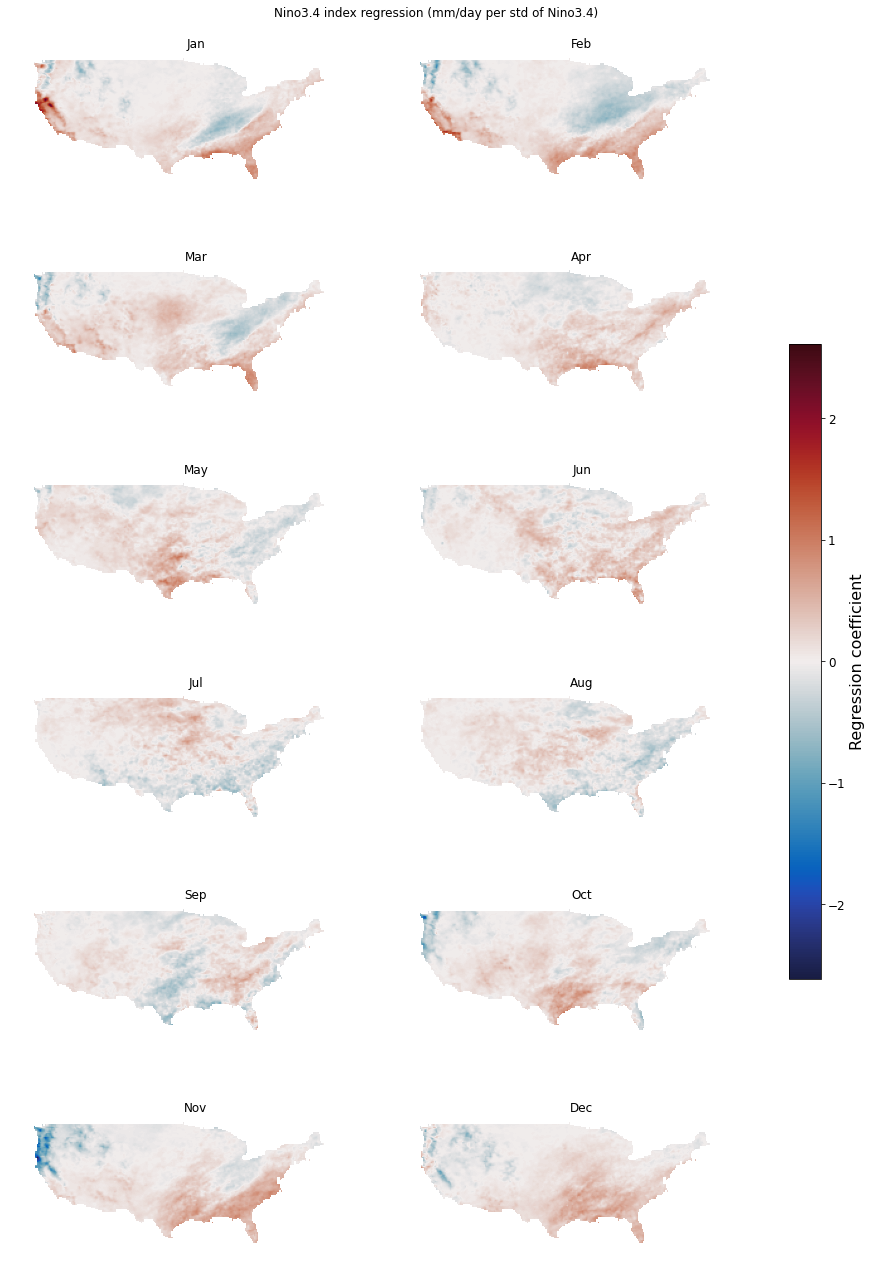

In [159]:
cbar_amp = np.nanmax(np.abs(rp))
fig, axs = plt.subplots(6,2,figsize = (12,18), constrained_layout = True)
im = axs[0,0].imshow(np.flipud(rp[0,:,:]), cmap = cmocean.cm.balance, vmin = -cbar_amp, vmax = cbar_amp)
axs[0,0].set_title('Jan')
axs[0,0].axis('off')
axs[0,1].imshow(np.flipud(rp[1,:,:]), cmap = cmocean.cm.balance, vmin = -cbar_amp, vmax = cbar_amp)
axs[0,1].set_title('Feb')
axs[0,1].axis('off')
axs[1,0].imshow(np.flipud(rp[2,:,:]), cmap = cmocean.cm.balance, vmin = -cbar_amp, vmax = cbar_amp)
axs[1,0].set_title('Mar')
axs[1,0].axis('off')
axs[1,1].imshow(np.flipud(rp[3,:,:]), cmap = cmocean.cm.balance, vmin = -cbar_amp, vmax = cbar_amp)
axs[1,1].set_title('Apr')
axs[1,1].axis('off')
axs[2,0].imshow(np.flipud(rp[4,:,:]), cmap = cmocean.cm.balance, vmin = -cbar_amp, vmax = cbar_amp)
axs[2,0].set_title('May')
axs[2,0].axis('off')
axs[2,1].imshow(np.flipud(rp[5,:,:]), cmap = cmocean.cm.balance, vmin = -cbar_amp, vmax = cbar_amp)
axs[2,1].set_title('Jun')
axs[2,1].axis('off')
axs[3,0].imshow(np.flipud(rp[6,:,:]), cmap = cmocean.cm.balance, vmin = -cbar_amp, vmax = cbar_amp)
axs[3,0].set_title('Jul')
axs[3,0].axis('off')
axs[3,1].imshow(np.flipud(rp[7,:,:]), cmap = cmocean.cm.balance, vmin = -cbar_amp, vmax = cbar_amp)
axs[3,1].set_title('Aug')
axs[3,1].axis('off')
axs[4,0].imshow(np.flipud(rp[8,:,:]), cmap = cmocean.cm.balance, vmin = -cbar_amp, vmax = cbar_amp)
axs[4,0].set_title('Sep')
axs[4,0].axis('off')
axs[4,1].imshow(np.flipud(rp[9,:,:]), cmap = cmocean.cm.balance, vmin = -cbar_amp, vmax = cbar_amp)
axs[4,1].set_title('Oct')
axs[4,1].axis('off')
axs[5,0].imshow(np.flipud(rp[10,:,:]), cmap = cmocean.cm.balance, vmin = -cbar_amp, vmax = cbar_amp)
axs[5,0].set_title('Nov')
axs[5,0].axis('off')
axs[5,1].imshow(np.flipud(rp[11,:,:]), cmap = cmocean.cm.balance, vmin = -cbar_amp, vmax = cbar_amp)
axs[5,1].set_title('Dec')
axs[5,1].axis('off')
fig.suptitle('Nino3.4 index regression (mm/day per std of Nino3.4)')
cbar = fig.colorbar(im,ax = axs[:,1], location='right', shrink = 0.5)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Regression coefficient', fontsize = 16)
# plt.colorbar()

Before reading too much into the patterns in these correlations, we should test for statistical significance.

To test statistical significance, we here use a 2-tailed t-test to see if correlation exceeds the threshold value at each point. For simiplicity, we treat each point independently and assume that consecutive years are independent. The null hypothesis is that the correlation is zero, the alternative is that it is non-zero. We choose a significance level of $p = 0.05$. Therefore the critical t value to exceed is: 

$t_c = 1.9955$

Let's go ahead and find the locations and months when the correlation is strong enough to pass the t-test at 95%:

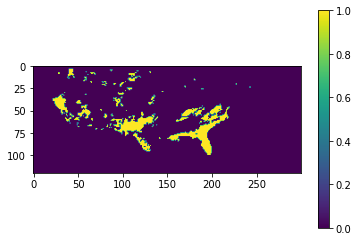

In [213]:
t_c = 1.9955
t = (68-2)**0.5*rc/(1-rc**2)**0.5

# create array containing success/fail result of t test for each point: 0 = fail, 1 = pass
test = np.zeros_like(t)
test[~np.isnan(t)] = np.abs(t[~np.isnan(t)])>t_c

plt.imshow(np.flipud(test[0,:,:]))
plt.colorbar()


Now we'll re-plot the regressions but with regions of statistical significance indicated by stipling:

Text(0.5, 0.98, 'Regression of Nino 3.4 on precipitation with 95% significant regions (mm/day per std of Nino3.4)')

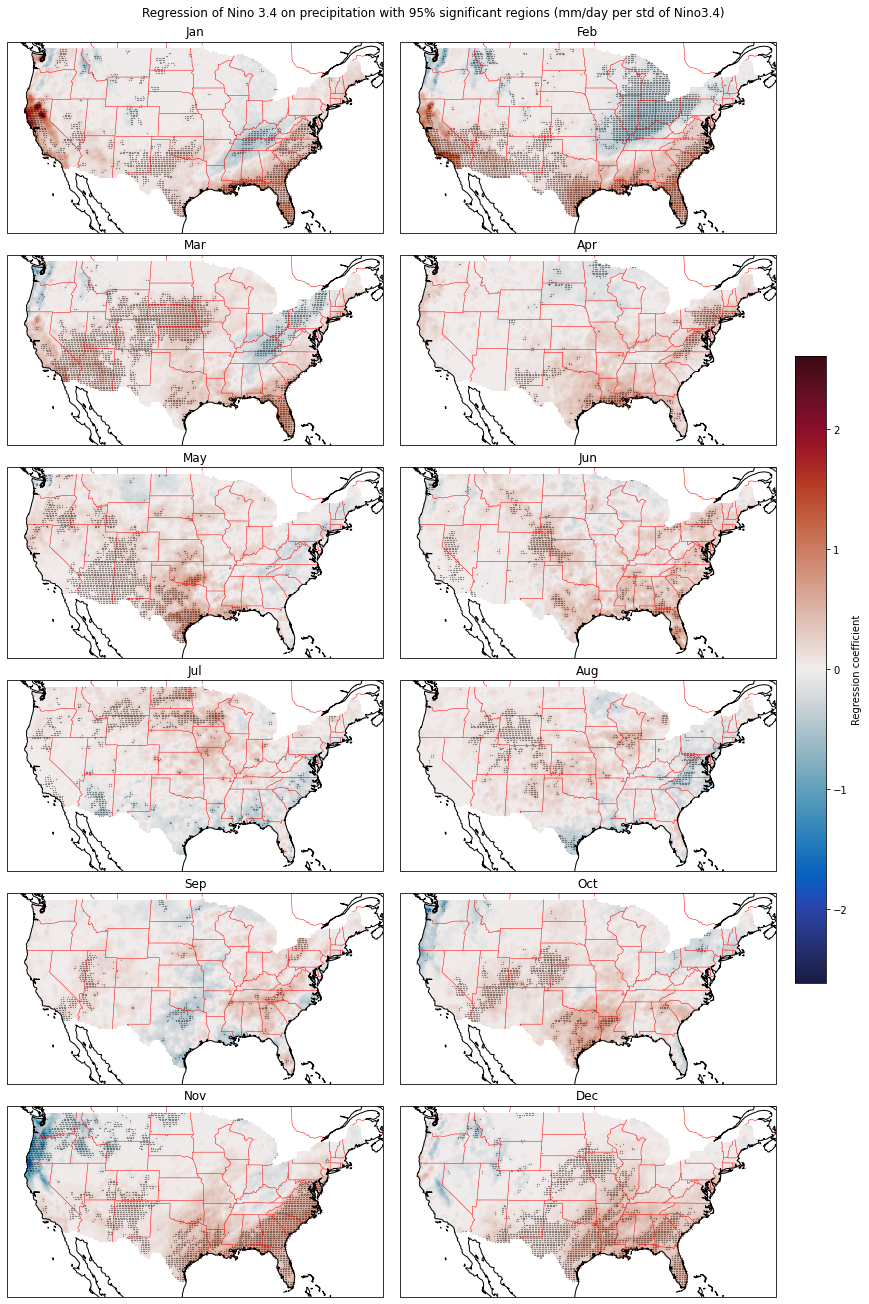

In [271]:
lon_plot, lat_plot = np.meshgrid(lon, lat)
cbar_amp = np.nanmax(np.abs(rp))
fig, axs = plt.subplots(6,2,figsize=(12, 18), subplot_kw = {'projection':ccrs.Robinson(central_longitude=-90)}, constrained_layout = True)
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
counter = 0
for i in range(6):
    for j in range(2):
        axs[i,j].contourf(lon, lat, rp[counter,:,:], 60,
                     transform=ccrs.PlateCarree(), cmap = cmocean.cm.balance, vmin = -cbar_amp, vmax = cbar_amp)

        test_plot = test[counter,]

        axs[i,j].scatter(lon_plot[test_plot!=0], lat_plot[test_plot!=0], transform=ccrs.PlateCarree(),s=0.1, marker = '.', color = 'black')
        axs[i,j].add_feature(states50, zorder=1, linewidth=0.5)
        axs[i,j].coastlines()
        axs[i,j].set_title(months[counter])
        counter+=1

cmap = cmocean.cm.balance
norm = mpl.colors.Normalize(vmin=-cbar_amp, vmax=cbar_amp)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax = axs[:,1], location = 'right', shrink = 0.5, label = 'Regression coefficient')
fig.suptitle('Regression of Nino 3.4 on precipitation with 95% significant regions (mm/day per std of Nino3.4)')

## Discussion

If I had more time, I would repeat the analysis for Nino3 and Nino4 indices and compare and contrast, but I don't, so I'll just discuss the patterns in the Nino3.4 results...

The following statistically significant correlations seem to exist between the Nino3.4 index and observed precipitation:

* The Southeast sees more precipitation in Winter months during years with +ve Nino3.4 (El Nino)
* The desert Southwest sees more precipitation in El Nino years in the Spring
* The Midwest sees less precipitation in El Nino years in the Spring
* California experiences wetter winters in El Nino years
* Nino 3.4 is a poor predictor of precipitation in most of the USA for most seasons, especially in the Summer
* Precipitation in the PNW and Northeast shows few statistically significant correlations with Nino 3.4